## Synthesizing building blocks

In [1]:
import cobra
from qbio_resources.plotting_functions import substrate_name_to_rxn, plot_theoretical_yields
from matplotlib import pyplot
%matplotlib inline

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def run_and_plot_simulations(cons_model, target_rxn, aerobic=True):
    yield_list = []
    substrate_list = []
    rxn_count = []
        
    for met, met_id in substrate_name_to_rxn.items():

        model.objective = target_rxn
        model.reactions.ATPM.lower_bound = 0
        model.reactions.EX_o2_e.lower_bound = -1000 if aerobic else 0
        model.reactions.EX_glc__D_e.lower_bound = 0

        model.reactions.get_by_id(met_id).lower_bound = -10
        sol = cobra.flux_analysis.pfba(model)


        model.reactions.get_by_id(met_id).lower_bound = 0

        if abs(sol.f) < .001 or abs(sol.x_dict[met_id]) < .001:
            rxn_count.append(0)
            yield_list.append(0)
            substrate_list.append(met)

            continue
        
        carbon_yield = sol.f / abs(sol.x_dict[met_id])

        count = 0
        for r, v in sol.x_dict.items():
            if abs(v) > 1e-6:
                count += 1

        rxn_count.append(count)
        yield_list.append(carbon_yield)
        substrate_list.append(met)

    plot_theoretical_yields(yield_list, substrate_list, 'Histidine', rxn_count)
    return yield_list, substrate_list, rxn_count

----
## A) Simulating carbon yield of key biomass components for 10 substrates

Simulate the maximum theoretical yield of the following biomass components
 - Histidine
 - ATP hydrolysis (using ATPM)
 - Charged SAM (by optimizing artificial SAM methylation reaction)
 
from the dictionary of substrates below

In [3]:
print(substrate_name_to_rxn)

{'D-Glucose': 'EX_glc__D_e', 'L-Glutamate': 'EX_glu__L_e', 'L-Glutamine': 'EX_gln__L_e', 'D-Ribose': 'EX_rib__D_e', 'L-Lysine': 'EX_lys__L_e', 'D-Lactate': 'EX_lac__D_e', 'L-Aspartate': 'EX_asp__L_e', 'Formate': 'EX_for_e', 'Adenosine': 'EX_adn_e', 'Acetate': 'EX_ac_e'}


### 1) Loop through the substrates and optimize for histidine productions

- Use -10 $\frac{mmol}{gDW \cdot hr}$ as the lower bound for each substrate
- Store the maximum theoretical yield in a `list` called `yield_list`
  - Divide the maximum feasible secretion flux by the absolute value of the uptake flux of the substrate to get the yield
- Store the substrate names in a `list` called `substrate_list`
- Store the number of reactions active in each condition in a `list` called `num_reaction_list`
  - Only consider reactions with an absolute flux value $\geq 10^{-6}$ 
- Use `cobra.flux_analyis.pfba()` function like in Exercise 1 to simulate model
  - This will give the minimal set of reactions that must be active
  
**Hint:** You will be reusing the same code to run each of the following analyses. It might be worth writing a function to do this.

In [4]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.ATPM.lower_bound = 0

In [5]:
yield_list = []
substrate_list = []
num_reaction_list = []
for name, uptake_rxn in substrate_name_to_rxn.items():
    model.reactions.EX_glc__D_e.lower_bound = 0
    model.reactions.get_by_id(uptake_rxn).lower_bound = -10
    model.objective = 'EX_his__L_e'
    solution = model.optimize()
    substrate_list.append(name)
    
    count = 0
    for r, flux in solution.fluxes.items():
        if abs(flux) >= 1e-6:
            count += 1

    num_reaction_list.append(count)
    
    
    if abs(solution.f) < .001:
        yield_value = 0
    else:
        yield_value = solution.fluxes['EX_his__L_e'] / abs(solution.fluxes[uptake_rxn])
    
    yield_list.append(yield_value)
    model.reactions.get_by_id(uptake_rxn).lower_bound = 0

### 2) Use the `plot_theoretical_yields()` function imported above to visualize results

This function takes the following arguments (in order):
1. List of substrate yields
2. List of substrate names
3. The name of the metabolite that was optimized for
4. List of the reactions active in the simulation

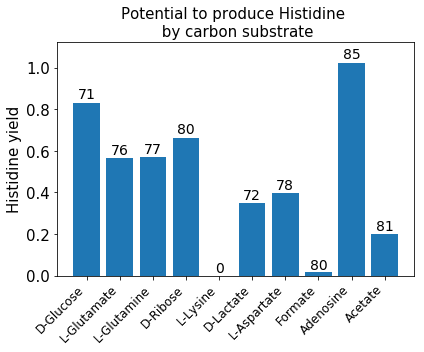

In [6]:
plot_theoretical_yields(yield_list, substrate_list, 'Histidine', num_reaction_list)

### 3) Visualize the correlation (or lack thereof) between the maximum theoretical yield and number of reaction active

 - Use matplotlib's scatter plot function which can be excuted with `pyplot.scatter(x_values, y_values)` where `x_values` and `y_values` corresponde to lists of values that should be plotted on the x and y axis, respectively
 
 - Add x and y axis labels with `pyplot.xlabel(label_string)` and `pyplot.ylabel(label_string)` 

Text(0,0.5,'Maximum Theoretical Yield')

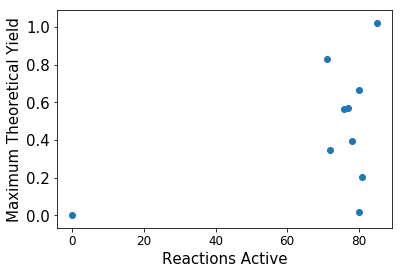

In [7]:
pyplot.scatter(num_reaction_list, yield_list)
pyplot.xlabel('Reactions Active')
pyplot.ylabel('Maximum Theoretical Yield')

### 4) Repeat above analysis for anaerobic histidine production

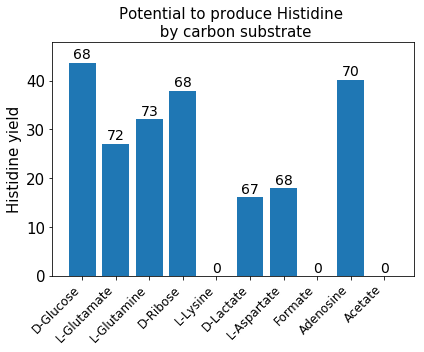

In [8]:
yield_list, substrate_names, num_reaction_list = run_and_plot_simulations(model, 'EX_his__L_e', aerobic=False)

Text(0,0.5,'Maximum Theoretical Yield')

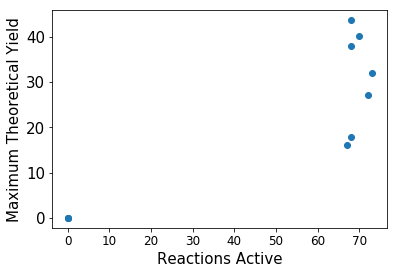

In [9]:
pyplot.scatter(num_reaction_list, yield_list)
pyplot.xlabel('Reactions Active')
pyplot.ylabel('Maximum Theoretical Yield')

### 4) Repeat above analysis for aerobic and anaerobic ATP production

To do this, we will use the non-growth associated ATP maintenance reaction (ATPM). This reaction is used to model cellular ATP demands that are not due to growth (mainaining ion gradients, etc.) and has the following form:

In [10]:
model.reactions.ATPM.reaction

'atp_c + h2o_c --> adp_c + h_c + pi_c'

Therefore maximizing flux through this ATP hydrolyis reaction will give an idication of the maximum amount of ATP that can be produced from a substrate.

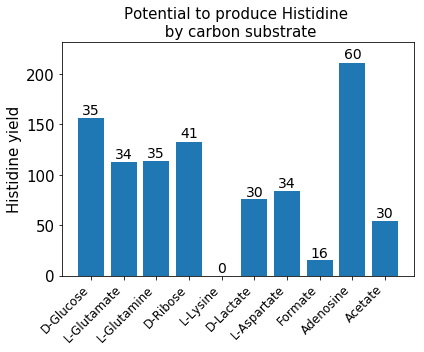

In [11]:
yield_list, substrate_names, num_reaction_list = run_and_plot_simulations(model, 'ATPM', aerobic=True)

Text(0,0.5,'Maximum Theoretical Yield')

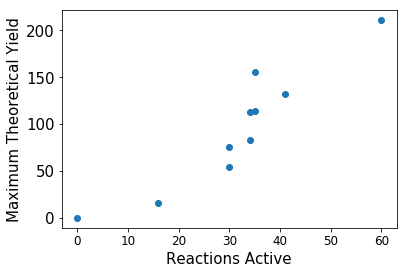

In [12]:
pyplot.scatter(num_reaction_list, yield_list)
pyplot.xlabel('Reactions Active')
pyplot.ylabel('Maximum Theoretical Yield')

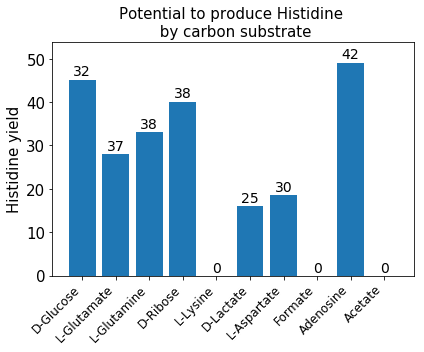

In [13]:
yield_list, substrate_names, num_reaction_list = run_and_plot_simulations(model, 'ATPM', aerobic=False)

Text(0,0.5,'Maximum Theoretical Yield')

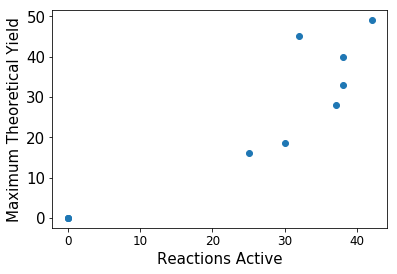

In [14]:
pyplot.scatter(num_reaction_list, yield_list)
pyplot.xlabel('Reactions Active')
pyplot.ylabel('Maximum Theoretical Yield')

---
## B) Assess solution variability
One caveat of COBRA methods is that an optimal FBA solution is not unique. In fact there exists an infinite number of alternative optimal solutions that fall within what is called a "solution space". Therefore many model predictions require that this reality is addressed in order to ensure that these predictions are meaningful.

A common way to get an understanding of solution variability is called "flux variability analysis" (FVA). This section will outline how this method is used.

### 1) Like above, optimize for the aerobic synthesis of histidine from glucose
- Save the maximum histidine synthesis flux in a variable called `max_flux`

In [15]:
model.objective = 'EX_his__L_e'
model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_o2_e.lower_bound = -100
max_flux = model.optimize().f

### 2) Set the upper and lower bound of the histidine production flux equal to `max_flux`

In [16]:
model.reactions.EX_his__L_e.lower_bound = max_flux
model.reactions.EX_his__L_e.upper_bound = max_flux

### 3) Find the maximum and minimum flux possible through phosphofructokinase (PFK) at the maximum histidine synthesis condition
**Hint:** the minimum flux can be found by executing `model.optimize('minimize')`

In [17]:
model.objective = 'PFK'
print('Maximum flux:', model.optimize().f)
print('Minimum flux:',model.optimize('minimize').f)

Maximum flux: 2.44186046511642
Minimum flux: 0.0


### 4) Return the objective to `EX_his__L_e` and return `EX_his__L_e`'s default bounds (lower_bound = 0, upper_bound = 1000)

In [18]:
model.objective = 'EX_his__L_e'
model.reactions.EX_his__L_e.lower_bound = 0
model.reactions.EX_his__L_e.upper_bound = 1000

### 5) Perform flux variability analysis on every reaction in the model

 - Use the cobra function `cobra.flux_analysis.flux_variability_analysis()` with `fraction_of_optimum=1`. This will perform the optimizations above on every reaction in the model at the optimal solution.

 - Store the output in a variable called `fva_solution`

In [19]:
fva_solution = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=1)

### 6) Remove values from `fva_solution` with 'maximum' and 'minimum' absolute values < $10^{-3}$ 

- Store the resulting values in two lists `maximum_flux` and `minimum_flux` 

**Hint:** 

1) The maximum or minimum values of can be obtained from `fva_solution` with:

In [20]:
fva_solution['maximum'].values

array([2.89920946e-12, 7.58863639e-18, 4.40328315e-15, ...,
       5.09098913e-11, 1.33032980e-13, 1.30636716e-13])

2) Two lists of equal length can be looped through together using `zip` like below

In [21]:
a = [1, 2, 3]
b = [4, 5, 6]
for i1, i2 in zip(a,b):
    print(i1, i2)

1 4
2 5
3 6


In [22]:
maximum_flux = []
minimum_flux = []

for i, v in zip(fva_solution['maximum'].values, fva_solution['minimum'].values) :
    if abs(i)< .001 and abs(v) < 0.001:
        continue
    maximum_flux.append(i)
    minimum_flux.append(v)

### 7) Visualize the variability of the reactions in the optimal solution using the `plot_variability()` function below

In [23]:
def plot_variability(maximum_flux, minimum_flux):
    x_array = list(range(0, len(maximum_flux)))
    pyplot.semilogy(x_array, minimum_flux, x_array, maximum_flux, '#1f77b4')
    pyplot.fill_between(x_array, minimum_flux, maximum_flux)
    pyplot.fill()
    pyplot.yscale('symlog')
    pyplot.xlabel('Reaction')
    pyplot.ylabel('Max and min flux possible in model')

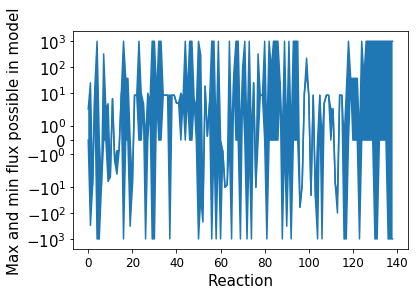

In [24]:
plot_variability(maximum_flux, minimum_flux)

----
## C) Sampling the solution space

Methods have been developed to try to address the uncertainty in solutions that comes from alternate optimimal solutions. One such method is called "solution space sampling". This approach involves performing the optimation many times (10,000+ simulations) until the entirety of the solution space has been effictively sampled. This ultimately provides prediction of which reactions/fluxes are most "likely" within a solution. 

This section will outline how this approach can be implemented.

### 1) Like above, set the lower and upper bound of histidine exchange equal to the optimal glucose aerobic synthesis flux 

In [25]:
max_flux = model.optimize().f
model.reactions.EX_his__L_e.lower_bound = max_flux
model.reactions.EX_his__L_e.upper_bound = max_flux

### 2) Sample the model 100 times using `cobra.flux_analysis.sample()` function
- This may take a few minutes to run
- Save the output in a variable called `sampled_fluxes` 

In [26]:
%%time
sampled_fluxes = cobra.flux_analysis.sample(model, 300)

CPU times: user 2min 3s, sys: 3.59 s, total: 2min 6s
Wall time: 1min 51s


### 3) Look up the sampled distribution of fluxes for glucose uptake 
This a reaction that we would expect to show no variability at the optimal solution as it is the limiting substrate

**Hint:** `sampled_fluxes` is a pandas `DataFrame` whose columns correspond to each reaction in the model. The values in a column can be found by executing `data_frame_variable['column_name']`

In [27]:
sampled_fluxes['EX_glc__D_e']

0     -10.0
1     -10.0
2     -10.0
3     -10.0
4     -10.0
5     -10.0
6     -10.0
7     -10.0
8     -10.0
9     -10.0
10    -10.0
11    -10.0
12    -10.0
13    -10.0
14    -10.0
15    -10.0
16    -10.0
17    -10.0
18    -10.0
19    -10.0
20    -10.0
21    -10.0
22    -10.0
23    -10.0
24    -10.0
25    -10.0
26    -10.0
27    -10.0
28    -10.0
29    -10.0
       ... 
270   -10.0
271   -10.0
272   -10.0
273   -10.0
274   -10.0
275   -10.0
276   -10.0
277   -10.0
278   -10.0
279   -10.0
280   -10.0
281   -10.0
282   -10.0
283   -10.0
284   -10.0
285   -10.0
286   -10.0
287   -10.0
288   -10.0
289   -10.0
290   -10.0
291   -10.0
292   -10.0
293   -10.0
294   -10.0
295   -10.0
296   -10.0
297   -10.0
298   -10.0
299   -10.0
Name: EX_glc__D_e, Length: 300, dtype: float64

### 4) Visualize the variability of the following reactions as a histogram
Attempt to infer the most "likely" fluxes that would be carried by the following reactions:

1. Phosphofructokinase (PFK)
2. Glucose-6-phosophate Isomerase (PGI)
3. Phosphopentomutase (PPM)
4. L-aspartate uptake via facillitated diffusion (ASPtpp)

**Hints:** 

1) The method for retrieving column values above return a pandas `Series`. This data type has a method that can be used to easily create histagrams with `series_variable_name.hist()`

2) Set the number of bins to 25

3) The `series_variable_name.hist()` function returns an intance of a matplotlib axis. Set this to a variable named `ax`.

4) The x-axis and y-axis labels can be set using `ax.set_xlabel` and `ax.set_ylabel`, respectively
    - The flux value of the sampling should be plotted on the x-axis and the number of sampling solutions corresponding to that flux value should be plotted on the y-axis

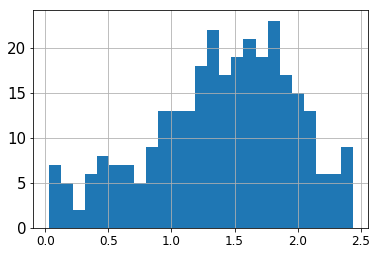

In [28]:
# Uncertain
sampled_fluxes['PFK'].hist(bins=25)

Text(0,0.5,'Number of Simulations')

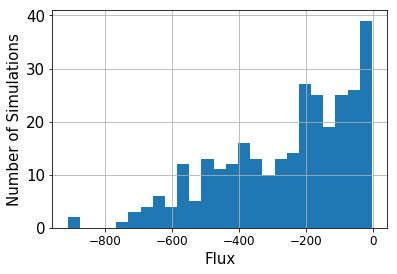

In [35]:
# Skewed to zero
ax = sampled_fluxes['PPM'].hist(bins=25)
ax.set_xlabel('Flux')
ax.set_ylabel('Number of Simulations')

Text(0,0.5,'Number of Simulations')

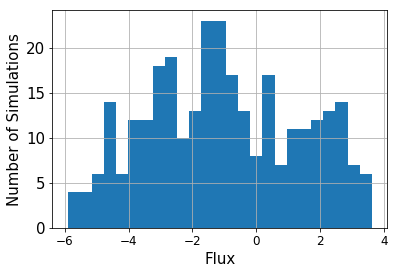

In [30]:
# Middlish
ax = sampled_fluxes['PGI'].hist(bins=25)
ax.set_xlabel('Flux')
ax.set_ylabel('Number of Simulations')

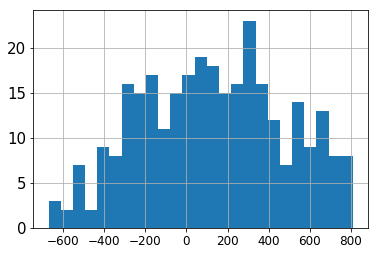

In [31]:
# Uncertain
sampled_fluxes['ASPtpp'].hist(bins=25)